In [81]:
import pandas as pd
import numpy as np
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Annotated
from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.types import Command
from langchain_core.tools import tool
from pydantic import BaseModel,Field,field_validator
from typing import List,Dict

In [82]:
import os
load_dotenv()
api_key = os.environ["OPENAI_API_KEY"]

In [83]:
## loading my llm into my system
llm = ChatOpenAI(model="gpt-4",api_key = api_key)

In [84]:
## testing my llm
llm.invoke("what is machine learning and Data Science").content ## my llm is working fine

'Machine Learning and Data Science are two interrelated fields of study, both revolving around the usage and analysis of data.\n\nMachine Learning is a subdivision of artificial intelligence (AI) that focuses on the development of algorithms and statistical models that enable computers to perform tasks without needing explicit instruction. In simpler terms, machine learning allows computers to learn from data and improve from experience, just like humans do. \n\nTypes of machine learning include supervised learning (where the computer is trained on a set of data), unsupervised learning (where the computer learns patterns and relationships from data it is not trained on), and reinforcement learning (where the computer learns by interacting with an environment).\n\nData Science, on the other hand, is a multidisciplinary field that uses scientific methods, algorithms, and systems to extract knowledge and insights from structured and unstructured data. It utilises techniques and theories f

In [85]:
data = pd.read_csv("data\hospitals_database_modified (1).csv")

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Global\AppData\Local\Temp\ipykernel_9396\3451261336.py:1: SyntaxWarning: invalid escape sequence '\h'
  data = pd.read_csv("data\hospitals_database_modified (1).csv")


In [86]:
data.head()

,hospital_name,doctor_name,qualification,specialization,doctor_phone,doctor_email,doctors_age,yoe,hospital_exact_location,disease_related,gender,available_for_online_consultation,avialable_slots,ratings(out_of_5),consultation_fee
0,Aastha Hospital,Dr. Suresh Thakur,"MBBS, DM",General Surgeon,+91-9653128782,suresh.thakur697@gmail.com,41,8.0,"Krishna Nagar, Hamirpur",General Surgery,Male,Yes,"10:00 AM - 2:00 PM, 5:00 PM - 7:00 PM",3.7,1426
1,Aastha Hospital,Dr. Rahul Chauhan,MBBS,Orthopedic Surgeon,+91-8797922150,rahul.chauhan492gmail.com,42,9.0,"Krishna Nagar, Hamirpur",Bone & Joint Problems,Male,Yes,"10:00 AM - 2:00 PM, 5:00 PM - 7:00 PM",3.8,1160
2,Aastha Hospital,Dr. Priya Singh,"MBBS, DM",Pediatrician,+91-9727757862,priya.singh115@gmail.com,30,3.0,"Sujanpur Tira, Hamirpur",Child Health Issues,Female,No,10:00 AM - 2:00 PM,3.3,1430
3,Aastha Hospital,Dr. Arun Chauhan,"MBBS, MCh",Neurologist,+91-8570163008,arun.chauhan76@gmail.com,39,4.0,"Main Market, Hamirpur",Brain Disorders,Male,No,10:00 AM - 2:00 PM,3.4,1395
4,Aastha Hospital,Dr. Rohit Jaiswal,"MBBS, MS",Dermatologist,+91-9793310222,rohit.jaiswal417@gmail.com,39,2.0,"Dugha, Hamirpur",Skin Problems,Male,No,4:00 PM - 8:00 PM,3.2,1344


In [87]:
data.columns

Index(['hospital_name', 'doctor_name', 'qualification', 'specialization',
       'doctor_phone', 'doctor_email', 'doctors_age', 'yoe',
       'hospital_exact_location', 'disease_related', 'gender',
       'available_for_online_consultation', 'avialable_slots',
       'ratings(out_of_5)', 'consultation_fee'],
      dtype='object')

In [88]:
len(data.columns)

15

In [89]:
data["specialization"].unique()

array(['General Surgeon', 'Orthopedic Surgeon', 'Pediatrician',
       'Neurologist', 'Dermatologist', 'Gynecologist', 'Eye Specialist',
       'Cardiologist', 'ENT Specialist', 'Oncologist'], dtype=object)

In [90]:
len(data["specialization"].unique())

10

In [91]:
data["hospital_name"].unique()

array(['Aastha Hospital',
       'Dr Radhakrishnan Govt Medical College Hospital, Hamirpur',
       'Hamirpur Medical Centre 3', 'City Hospital Hamirpur',
       'Sai Hospital & IVF Center', 'Himachal Head Neck Hospital',
       'Thakur Surgical & Maternity Nursing Home', 'Nav Bharati Clinic',
       'Aapka Hospital', 'Minhas Hospital (Nadaun)',
       'V Care Medical Centre',
       'Regional (District) Ayurvedic Hospital, Hamirpur',
       'Lady Willnagton Hospital', 'Govt Hospital', 'Krishana Hospital'],
      dtype=object)

In [92]:
len(data["hospital_name"].unique())

15

In [93]:
data["disease_related"].unique()

array(['General Surgery', 'Bone & Joint Problems', 'Child Health Issues',
       'Brain Disorders', 'Skin Problems', 'General Treatment',
       'Heart Problems'], dtype=object)

In [94]:
len(data["disease_related"].unique())

7

In [95]:
data["disease_related"].nunique()

7

In [96]:
data["gender"].unique()

array(['Male', 'Female'], dtype=object)

In [226]:
class State(TypedDict):
    query_dict:dict
    gender_response:dict
    specialization_response:dict
    online_consultation_response:dict
    consultation_fee_response:dict
    disease_related_response:dict
    response_dict:dict
    final_data:str
    final_df:pd.DataFrame
    final_response:str
    dfs:List[pd.DataFrame]


In [98]:
data[data["gender"] == "Male"].to_dict(orient="records")

[{'hospital_name': 'Aastha Hospital',
  'doctor_name': 'Dr. Suresh Thakur',
  'qualification': 'MBBS, DM',
  'specialization': 'General Surgeon',
  'doctor_phone': '+91-9653128782',
  'doctor_email': 'suresh.thakur697@gmail.com',
  'doctors_age': 41,
  'yoe': 8.0,
  'hospital_exact_location': 'Krishna Nagar, Hamirpur',
  'disease_related': 'General Surgery',
  'gender': 'Male',
  'available_for_online_consultation': 'Yes',
  'avialable_slots': '10:00 AM - 2:00 PM, 5:00 PM - 7:00 PM',
  'ratings(out_of_5)': 3.7,
  'consultation_fee': 1426},
 {'hospital_name': 'Aastha Hospital',
  'doctor_name': 'Dr. Rahul Chauhan',
  'qualification': 'MBBS',
  'specialization': 'Orthopedic Surgeon',
  'doctor_phone': '+91-8797922150',
  'doctor_email': 'rahul.chauhan492gmail.com',
  'doctors_age': 42,
  'yoe': 9.0,
  'hospital_exact_location': 'Krishna Nagar, Hamirpur',
  'disease_related': 'Bone & Joint Problems',
  'gender': 'Male',
  'available_for_online_consultation': 'Yes',
  'avialable_slots': '1

In [161]:
def gender_filter(state:State)->dict:
    query_dict = state.get("query_dict",{})
    gender_response = state.get("gender_response",{})
    gender = query_dict.get("gender")
    if gender == None:
        gender_response["gender"] = None 
        
    else:
        filtered = data[data["gender"] == gender]
        gender_response["gender"] = filtered

    return {"gender_response":gender_response}     

In [162]:
def online_consultation_filter(state:State)->dict:
    query_dict = state.get("query_dict",{})
    
    online_consultation_response= state.get("online_consultation_response",{})
    online_consultation = query_dict.get("online_consultation")
    if online_consultation == None:
        online_consultation_response["online_consultation"] = None 
        
    else:
        filtered = data[data["available_for_online_consultation"] == online_consultation]
        online_consultation_response["online_consultation"] = filtered

    return {"online_consultation_response":online_consultation_response}

In [101]:
data["consultation_fee"]

0      1426
1      1160
2      1430
3      1395
4      1344
       ... 
295    1153
296    1261
297     454
298     789
299    1084
Name: consultation_fee, Length: 300, dtype: int64

In [163]:
def consultation_fees_filter(state:State)->dict:
    query_dict = state.get("query_dict",{})
    consultation_fee_response = state.get("consultation_fee_response",{})
    consultation_fees = query_dict.get("consultation_fees")
    if consultation_fees == None:
        consultation_fee_response["consultation_fees"] = None 
        
    else:
        filtered = data[data["consultation_fee"] <= consultation_fees]
        consultation_fee_response["consultation_fees"] = filtered

    return {"consultation_fee_response":consultation_fee_response}

In [164]:
def specialization_filter(state:State)->dict:
    query_dict = state.get("query_dict",{})
    specialization_response = state.get("specialization_response",{})
    specialization = query_dict.get("specialization")
    if specialization == None:
        specialization_response["specialization"] = None 
        
    else:
        filtered = data[data["specialization"] == specialization]
        specialization_response["specialization"] = filtered

    return {"specialization_response":specialization_response}

In [104]:
data["specialization"].unique()

array(['General Surgeon', 'Orthopedic Surgeon', 'Pediatrician',
       'Neurologist', 'Dermatologist', 'Gynecologist', 'Eye Specialist',
       'Cardiologist', 'ENT Specialist', 'Oncologist'], dtype=object)

In [165]:
def disease_filter(state:State)->dict:
    query_dict = state.get("query_dict",{})
    disease_related_response = state.get("disease_related_response",{})
    disease = query_dict.get("disease_related")
    if disease == None:
        disease_related_response["disease_related"] = None 
        
    else:
        filtered = data[data["disease_related"] == disease]
        disease_related_response["disease_related"] = filtered

    return {"disease_related_response":disease_related_response}

In [106]:
data["disease_related"].unique()

array(['General Surgery', 'Bone & Joint Problems', 'Child Health Issues',
       'Brain Disorders', 'Skin Problems', 'General Treatment',
       'Heart Problems'], dtype=object)

In [166]:
class QueryModel(BaseModel):
    response:List[Dict] = Field(description="provide the list of doctors matching the criteria")

In [175]:
data["gender"].to_list()

['Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Female',
 'Female',
 'Female',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Female',
 'Female',
 'Male',
 'Male',
 'Male',
 'Female',
 'Female',
 'Male',
 'Male',
 'Female',
 'Male',
 'Female',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Female',
 'Male',
 'Male',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Female',
 'Male',
 'Female',
 'Male',
 'Female',
 'Male',
 'Male',


In [176]:
data.columns

Index(['hospital_name', 'doctor_name', 'qualification', 'specialization',
       'doctor_phone', 'doctor_email', 'doctors_age', 'yoe',
       'hospital_exact_location', 'disease_related', 'gender',
       'available_for_online_consultation', 'avialable_slots',
       'ratings(out_of_5)', 'consultation_fee'],
      dtype='object')

In [252]:
def generate_response(state:State):

    query_dict = state.get("query_dict",{})
    response_dict = state.get("response_dict",{})
    gender = state.get("gender_response").get("gender")
    online_consultation = state.get("online_consultation_response").get("online_consultation")
    consultation_fees = state.get("consultation_fee_response").get("consultation_fees")
    specialization = state.get("specialization_response").get("specialization")
    disease_related = state.get("disease_related_response").get("disease_related")
    dfs = [
    gender,
    online_consultation,
    consultation_fees,
    specialization,
    disease_related
]

    
    valid_dfs = [df for df in dfs if df is not None]
    final_df = valid_dfs[0].head()
    
    ## I am picking only the first five rows of the data 
    gender_list = final_df["gender"].to_list()
    hospital_name_list = final_df["hospital_name"].to_list()
    specialization_list = final_df["specialization"].to_list()
    consultation_fee_list = final_df["consultation_fee"].to_list()
    disease_related_list = final_df["disease_related"].to_list()
    available_for_online_consultation_list = final_df["available_for_online_consultation"].to_list()
    hospital_name = final_df["hospital_name"].to_list()
    doctor_name = final_df["doctor_name"].to_list()
    location = final_df["hospital_exact_location"].to_list()
    available_slots = final_df["avialable_slots"].to_list()

    final_data = " "

    for i in range(len(final_df)):
        response = f"Doctor Name: {doctor_name[i]}, Hospital Name: {hospital_name[i]}, Specialization: {specialization_list[i]}, Gender: {gender_list[i]}, Consultation Fee: {consultation_fee_list[i]}, Disease Related: {disease_related_list[i]}, Available for Online Consultation: {available_for_online_consultation_list[i]}, Location: {location[i]}, Available Slots: {available_slots[i]}"
        final_data += response + "\n\n"

    template = """You are an expert medical assistant. Based on the following filtered data, generate a concise and informative response for the user.
    Do not generate any response if there is no data available after filtering.Just say no doctors found matching the criteria.
    Think step by step and provide the final response.This is the filtered data: {final_data}"""



    
    
    prompt = PromptTemplate(template=template,input_variables=["final_data"])
    chain = prompt | llm
    result = chain.invoke({"final_data":final_data}).content
    return {"final_response":result,"final_data":final_data,"final_df":final_df,"dfs":dfs}

In [253]:
## all the functions are ready now we will create our state graph
graph = StateGraph(State)
graph.add_node("gender_filter",gender_filter)
graph.add_node("online_consultation_filter",online_consultation_filter)
graph.add_node("consultation_fees_filter",consultation_fees_filter)
graph.add_node("specialization_filter",specialization_filter)
graph.add_node("disease_filter",disease_filter)
graph.add_node("generate_response",generate_response)
graph.add_edge(START,"gender_filter")
graph.add_edge(START,"online_consultation_filter")
graph.add_edge(START,"consultation_fees_filter")
graph.add_edge(START,"specialization_filter")
graph.add_edge(START,"disease_filter")
graph.add_edge("gender_filter","generate_response")
graph.add_edge("online_consultation_filter","generate_response")
graph.add_edge("consultation_fees_filter","generate_response")
graph.add_edge("specialization_filter","generate_response")
graph.add_edge("disease_filter","generate_response")
graph.add_edge("generate_response",END)

app = graph.compile()

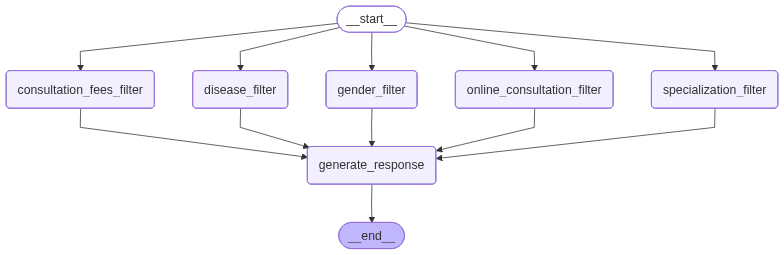

In [254]:
app

In [258]:
inputs = {"query_dict":{"gender":"Male","consultation_fees":100,"specialization":"Cardiologist","disease_related":"Heart Disease","online_consultation":"Yes"}}

In [259]:
response = app.invoke(inputs)

In [256]:
response

{'query_dict': {'gender': 'Male',
  'consultation_fees': 100,
  'specialization': 'Cardiologist',
  'disease_related': 'Heart Disease'},
 'gender_response': {'gender':          hospital_name         doctor_name qualification      specialization  \
  0      Aastha Hospital   Dr. Suresh Thakur      MBBS, DM     General Surgeon   
  1      Aastha Hospital   Dr. Rahul Chauhan          MBBS  Orthopedic Surgeon   
  3      Aastha Hospital    Dr. Arun Chauhan     MBBS, MCh         Neurologist   
  4      Aastha Hospital   Dr. Rohit Jaiswal      MBBS, MS       Dermatologist   
  5      Aastha Hospital    Dr. Deepak Verma      MBBS, MS        Gynecologist   
  ..                 ...                 ...           ...                 ...   
  289  Krishana Hospital  Dr. Karan Bhardwaj          MBBS        Pediatrician   
  290  Krishana Hospital   Dr. Rohit Mahajan      MBBS, MD        Gynecologist   
  294  Krishana Hospital     Dr. Rahul Singh          MBBS  Orthopedic Surgeon   
  295  Krishan

In [238]:
dfs = response["dfs"]

In [239]:
valid_dfs = [df for df in dfs if df is not None]
common_index = valid_dfs[0].index
for df in valid_dfs[1:]:
 common_index = common_index.intersection(df.index)

In [246]:
import pandas as pd
from functools import reduce

# list_of_dfs = [df1, df2, df3, ...]

final_df = reduce(lambda left, right: pd.merge(left, right, how='inner'), valid_dfs)


In [250]:
final_df = valid_dfs[0].head()

In [251]:
final_df

,hospital_name,doctor_name,qualification,specialization,doctor_phone,doctor_email,doctors_age,yoe,hospital_exact_location,disease_related,gender,available_for_online_consultation,avialable_slots,ratings(out_of_5),consultation_fee
0,Aastha Hospital,Dr. Suresh Thakur,"MBBS, DM",General Surgeon,+91-9653128782,suresh.thakur697@gmail.com,41,8.0,"Krishna Nagar, Hamirpur",General Surgery,Male,Yes,"10:00 AM - 2:00 PM, 5:00 PM - 7:00 PM",3.7,1426
1,Aastha Hospital,Dr. Rahul Chauhan,MBBS,Orthopedic Surgeon,+91-8797922150,rahul.chauhan492gmail.com,42,9.0,"Krishna Nagar, Hamirpur",Bone & Joint Problems,Male,Yes,"10:00 AM - 2:00 PM, 5:00 PM - 7:00 PM",3.8,1160
3,Aastha Hospital,Dr. Arun Chauhan,"MBBS, MCh",Neurologist,+91-8570163008,arun.chauhan76@gmail.com,39,4.0,"Main Market, Hamirpur",Brain Disorders,Male,No,10:00 AM - 2:00 PM,3.4,1395
4,Aastha Hospital,Dr. Rohit Jaiswal,"MBBS, MS",Dermatologist,+91-9793310222,rohit.jaiswal417@gmail.com,39,2.0,"Dugha, Hamirpur",Skin Problems,Male,No,4:00 PM - 8:00 PM,3.2,1344
5,Aastha Hospital,Dr. Deepak Verma,"MBBS, MS",Gynecologist,+91-7386829920,deepak.verma169@ gmail.com,56,12.0,"Sujanpur Tira, Hamirpur",General Treatment,Male,Yes,"10:00 AM - 2:00 PM, 5:00 PM - 7:00 PM",4.1,421


In [245]:
valid_dfs

[         hospital_name         doctor_name qualification      specialization  \
 0      Aastha Hospital   Dr. Suresh Thakur      MBBS, DM     General Surgeon   
 1      Aastha Hospital   Dr. Rahul Chauhan          MBBS  Orthopedic Surgeon   
 3      Aastha Hospital    Dr. Arun Chauhan     MBBS, MCh         Neurologist   
 4      Aastha Hospital   Dr. Rohit Jaiswal      MBBS, MS       Dermatologist   
 5      Aastha Hospital    Dr. Deepak Verma      MBBS, MS        Gynecologist   
 ..                 ...                 ...           ...                 ...   
 289  Krishana Hospital  Dr. Karan Bhardwaj          MBBS        Pediatrician   
 290  Krishana Hospital   Dr. Rohit Mahajan      MBBS, MD        Gynecologist   
 294  Krishana Hospital     Dr. Rahul Singh          MBBS  Orthopedic Surgeon   
 295  Krishana Hospital    Dr. Rahul Kapoor      MBBS, MS        Gynecologist   
 296  Krishana Hospital    Dr. Harsh Thakur      MBBS, MD          Oncologist   
 
        doctor_phone      

In [241]:
valid_dfs

[         hospital_name         doctor_name qualification      specialization  \
 0      Aastha Hospital   Dr. Suresh Thakur      MBBS, DM     General Surgeon   
 1      Aastha Hospital   Dr. Rahul Chauhan          MBBS  Orthopedic Surgeon   
 3      Aastha Hospital    Dr. Arun Chauhan     MBBS, MCh         Neurologist   
 4      Aastha Hospital   Dr. Rohit Jaiswal      MBBS, MS       Dermatologist   
 5      Aastha Hospital    Dr. Deepak Verma      MBBS, MS        Gynecologist   
 ..                 ...                 ...           ...                 ...   
 289  Krishana Hospital  Dr. Karan Bhardwaj          MBBS        Pediatrician   
 290  Krishana Hospital   Dr. Rohit Mahajan      MBBS, MD        Gynecologist   
 294  Krishana Hospital     Dr. Rahul Singh          MBBS  Orthopedic Surgeon   
 295  Krishana Hospital    Dr. Rahul Kapoor      MBBS, MS        Gynecologist   
 296  Krishana Hospital    Dr. Harsh Thakur      MBBS, MD          Oncologist   
 
        doctor_phone      

In [240]:
common_index

Index([], dtype='int64')

In [223]:
response.keys()

dict_keys(['query_dict', 'gender_response', 'specialization_response', 'online_consultation_response', 'consultation_fee_response', 'disease_related_response', 'final_data', 'final_df', 'final_response'])

In [260]:
response["final_response"]

'Here are the suitable doctors based on your criteria:\n\n1. Dr. Suresh Thakur, a General Surgeon at Aastha Hospital located in Krishna Nagar, Hamirpur. He is currently available for online consultation. His consultation fee is 1426 and he is available between 10:00 AM - 2:00 PM and 5:00 PM - 7:00 PM.\n\n2. Dr. Rahul Chauhan, an Orthopedic Surgeon also at Aastha Hospital in Krishna Nagar, Hamirpur. He deals with Bone & Joint Problems. His consultation fee is 1160 and is available for online consultation from 10:00 AM - 2:00 PM and 5:00 PM - 7:00 PM.\n\n3. Dr. Deepak Verma, a Gynecologist at Aastha Hospital located in Sujanpur Tira, Hamirpur. His areas of expertise include general treatment. He is available for online consultation and charges a fee of 421. You can consult him between 10:00 AM - 2:00 PM and 5:00 PM - 7:00 PM.\n\nPlease note that Dr. Arun Chauhan, a Neurologist, and Dr. Rohit Jaiswal, a Dermatologist are not available for online consultation at this point. However, you ca

In [218]:
response["final_data"]

' '

In [233]:
response["final_df"]

,hospital_name,doctor_name,qualification,specialization,doctor_phone,doctor_email,doctors_age,yoe,hospital_exact_location,disease_related,gender,available_for_online_consultation,avialable_slots,ratings(out_of_5),consultation_fee


In [234]:
response["dfs"]

[         hospital_name         doctor_name qualification      specialization  \
 0      Aastha Hospital   Dr. Suresh Thakur      MBBS, DM     General Surgeon   
 1      Aastha Hospital   Dr. Rahul Chauhan          MBBS  Orthopedic Surgeon   
 3      Aastha Hospital    Dr. Arun Chauhan     MBBS, MCh         Neurologist   
 4      Aastha Hospital   Dr. Rohit Jaiswal      MBBS, MS       Dermatologist   
 5      Aastha Hospital    Dr. Deepak Verma      MBBS, MS        Gynecologist   
 ..                 ...                 ...           ...                 ...   
 289  Krishana Hospital  Dr. Karan Bhardwaj          MBBS        Pediatrician   
 290  Krishana Hospital   Dr. Rohit Mahajan      MBBS, MD        Gynecologist   
 294  Krishana Hospital     Dr. Rahul Singh          MBBS  Orthopedic Surgeon   
 295  Krishana Hospital    Dr. Rahul Kapoor      MBBS, MS        Gynecologist   
 296  Krishana Hospital    Dr. Harsh Thakur      MBBS, MD          Oncologist   
 
        doctor_phone      

In [236]:
for i in response["dfs"]:
    print(i.head())
    print("\n\n")

     hospital_name        doctor_name qualification      specialization  \
0  Aastha Hospital  Dr. Suresh Thakur      MBBS, DM     General Surgeon   
1  Aastha Hospital  Dr. Rahul Chauhan          MBBS  Orthopedic Surgeon   
3  Aastha Hospital   Dr. Arun Chauhan     MBBS, MCh         Neurologist   
4  Aastha Hospital  Dr. Rohit Jaiswal      MBBS, MS       Dermatologist   
5  Aastha Hospital   Dr. Deepak Verma      MBBS, MS        Gynecologist   

     doctor_phone                doctor_email  doctors_age   yoe  \
0  +91-9653128782  suresh.thakur697@gmail.com           41   8.0   
1  +91-8797922150   rahul.chauhan492gmail.com           42   9.0   
3  +91-8570163008    arun.chauhan76@gmail.com           39   4.0   
4  +91-9793310222  rohit.jaiswal417@gmail.com           39   2.0   
5  +91-7386829920  deepak.verma169@ gmail.com           56  12.0   

   hospital_exact_location        disease_related gender  \
0  Krishna Nagar, Hamirpur        General Surgery   Male   
1  Krishna Nagar, Ha

AttributeError: 'NoneType' object has no attribute 'head'

In [159]:
response["gender_response"]

{'gender':          hospital_name         doctor_name qualification      specialization  \
 0      Aastha Hospital   Dr. Suresh Thakur      MBBS, DM     General Surgeon   
 1      Aastha Hospital   Dr. Rahul Chauhan          MBBS  Orthopedic Surgeon   
 3      Aastha Hospital    Dr. Arun Chauhan     MBBS, MCh         Neurologist   
 4      Aastha Hospital   Dr. Rohit Jaiswal      MBBS, MS       Dermatologist   
 5      Aastha Hospital    Dr. Deepak Verma      MBBS, MS        Gynecologist   
 ..                 ...                 ...           ...                 ...   
 289  Krishana Hospital  Dr. Karan Bhardwaj          MBBS        Pediatrician   
 290  Krishana Hospital   Dr. Rohit Mahajan      MBBS, MD        Gynecologist   
 294  Krishana Hospital     Dr. Rahul Singh          MBBS  Orthopedic Surgeon   
 295  Krishana Hospital    Dr. Rahul Kapoor      MBBS, MS        Gynecologist   
 296  Krishana Hospital    Dr. Harsh Thakur      MBBS, MD          Oncologist   
 
        doctor_p